# How to use:
<br>
This is the notebook that allows you grab data to move into the hard-code data.py.<br>
What this means is - to avoid long download times - downloads can be done beforehand then stored appropriatley.<br>
The notebook will return two arrays. <br>
The first array is the CHIRPS v-2.0 obs data. <br>
The second array is the ECMWF monthly statistcs Hindcast data. - it is ordered in years doing down the rows. And members going along the collumn. It is cut off at member 15. <br>
<br>
To move these to data.py just copy and paste the output and label the name appropriatley following the guidance in the commented seciton of that python file. 

In [35]:
import os
import requests
import cdsapi
from concurrent.futures import ThreadPoolExecutor

# Configuration variables
CONFIG = {
    "centre": "ecmwf",
    "system": "51",
    "month": 8,
    "leadtime_month": [3, 4, 5],
    "area": [4.0, 30.0, -1.0, 34.0], #N,W,S,E [Kenya - [5.0, 34.0, -5.0, 42.0] , Sudan - [25.0,20.0,5.0,40.0], South_Sudan -[15.0,20.0,0.0,40.0]
    "area_str": "4.0:30.0:-1.0:34.0",     # Uganda - [5.0,25.0,-5.0,35.0]
    "variable": "total_precipitation",
    "obs_variable": "total_precipitation",
    "hcstarty": 1993,
    "hcendy": 2016,
    "downloaddir": "data_down",
    "years": [str(y) for y in range(1993, 2017)]
}

os.makedirs(CONFIG["downloaddir"], exist_ok=True)

def do_cdsapi_call():
    """Download seasonal monthly single-level data from CDSAPI."""
    c = cdsapi.Client()
    leads_str = "".join(map(str, CONFIG["leadtime_month"]))
    fname = os.path.join(
        CONFIG["downloaddir"],
        f"{CONFIG['centre']}_{CONFIG['system']}_{CONFIG['years'][0]}-{CONFIG['years'][-1]}_monthly_mean_{CONFIG['month']}_{leads_str}_{CONFIG['area_str']}_{CONFIG['variable']}.grib"
    )

    if os.path.exists(fname):
        print(f'File {fname} already exists')
        return

    c.retrieve(
        "seasonal-monthly-single-levels",
        {
            "format": "grib",
            "originating_centre": CONFIG["centre"],
            "system": CONFIG["system"],
            "variable": [CONFIG["variable"]],
            "product_type": "monthly_mean",
            "year": CONFIG["years"],
            "month": f"{CONFIG['month']:02d}",
            "leadtime_month": CONFIG["leadtime_month"],
            "area": CONFIG["area"],
        },
        fname,
    )

def get_obs():
    """Download ERA5 reanalysis data from CDSAPI."""
    c = cdsapi.Client()
    obs_fname = os.path.join(
        CONFIG["downloaddir"],
        f"era5_{CONFIG['obs_variable']}_{CONFIG['hcstarty']}-{CONFIG['hcendy']}_monthly_{CONFIG['area_str']}.grib"
    )

    if os.path.exists(obs_fname):
        print(f'File {obs_fname} already exists')
        return obs_fname

    months = [
        f"{(CONFIG['month'] + leadm) % 12 or 12:02d}"
        for leadm in CONFIG["leadtime_month"]
    ]

    c.retrieve(
        'reanalysis-era5-single-levels-monthly-means',
        {
            'product_type': 'monthly_averaged_reanalysis',
            "variable": [CONFIG["obs_variable"]],
            'year': [str(yy) for yy in range(CONFIG["hcstarty"], CONFIG["hcendy"] + 2)],
            'month': months,
            'time': '00:00',
            'grid': '1/1',
            'area': CONFIG["area"],
            'format': 'grib',
        },
        obs_fname
    )
    return obs_fname

def download_chirps_data():
    """Download CHIRPS monthly data for specified years."""
    base_url = "https://data.chc.ucsb.edu/products/CHIRPS/v3.0/monthly/global/netcdf/by_year/" #https://data.chc.ucsb.edu/products/CHIRPS/v3.0/monthly/global/netcdf/by_year/
                                                                         # https://data.chc.ucsb.edu/products/CHIRPS/v3.0/monthly/global/netcdf/by_year/chirps-v3.0.1981.monthly.nc
    def download_file(year):
        file_name = f"chirps-v3.0.{year}.monthly.nc"
        url = f"{base_url}/{file_name}"
        output_path = os.path.join(CONFIG["downloaddir"], file_name)

        if os.path.exists(output_path):
            print(f"{file_name} already exists. Skipping...")
            return

        try:
            print(f"Downloading {file_name}...")
            response = requests.get(url, timeout=60)
            response.raise_for_status()
            with open(output_path, 'wb') as f:
                f.write(response.content)
            print(f"{file_name} download complete.")
        except requests.RequestException as e:
            print(f"Failed to download {file_name}: {e}")

    with ThreadPoolExecutor(max_workers=5) as executor:
        executor.map(download_file, range(CONFIG["hcstarty"], CONFIG["hcendy"] + 1))

def run_full_download_pipeline():
    """Run the full pipeline for downloading climate data."""
    do_cdsapi_call()
    #get_obs()
    download_chirps_data()

# Execute the pipeline
run_full_download_pipeline()


2025-08-12 15:27:51,219 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-08-12 15:27:51,542 INFO Request ID is 4772ff84-ab5d-4786-94c1-5a7f0197a2e0
2025-08-12 15:27:51,639 INFO status has been updated to accepted
2025-08-12 15:28:05,374 INFO status has been updated to running
2025-08-12 15:28:41,843 INFO status has been updated to successful


7d76bcc23a527b7c2478747b2b386698.grib:   0%|          | 0.00/345k [00:00<?, ?B/s]

chirps-v3.0.1993.monthly.nc already exists. Skipping...
chirps-v3.0.1994.monthly.nc already exists. Skipping...
chirps-v3.0.1995.monthly.nc already exists. Skipping...
chirps-v3.0.1996.monthly.nc already exists. Skipping...
chirps-v3.0.1998.monthly.nc already exists. Skipping...
chirps-v3.0.1997.monthly.nc already exists. Skipping...
chirps-v3.0.1999.monthly.nc already exists. Skipping...
chirps-v3.0.2000.monthly.nc already exists. Skipping...
chirps-v3.0.2001.monthly.nc already exists. Skipping...
chirps-v3.0.2002.monthly.nc already exists. Skipping...
chirps-v3.0.2003.monthly.nc already exists. Skipping...
chirps-v3.0.2004.monthly.nc already exists. Skipping...
chirps-v3.0.2005.monthly.nc already exists. Skipping...
chirps-v3.0.2006.monthly.nc already exists. Skipping...
chirps-v3.0.2007.monthly.nc already exists. Skipping...
chirps-v3.0.2008.monthly.nc already exists. Skipping...
chirps-v3.0.2009.monthly.nc already exists. Skipping...
chirps-v3.0.2010.monthly.nc already exists. Skip

The next cell arranges the CHIRPS OBS data too be in the correct manner for DATA.py

In [36]:
import numpy as np
import xarray as xr
import geopandas as gpd
import rioxarray
import cartopy.io.shapereader as shpreader
from shapely.geometry import mapping
import os
import shutil

# Load Kenya polygon from Natural Earth shapefile
country_set = "admin_0_countries"
shapefile_path = shpreader.natural_earth(resolution="10m", category="cultural", name=country_set)

# Ensure shapefile components are copied to local directory
if not os.path.exists('ecmwf'):
    os.makedirs('ecmwf')

for ext in [".shp", ".shx", ".dbf", ".prj", ".cpg"]:
    source_file = str(shapefile_path).replace(".shp", ext)
    shutil.copy(source_file, os.path.join('ecmwf', os.path.basename(source_file)))

# Load country polygons and filter for Kenya
geodf = gpd.read_file("ecmwf/ne_10m_admin_0_countries.shp")
kenya_geom = geodf[geodf['ADMIN'] == 'Uganda']

# Define OND months and years of interest
ond_months = [10, 11, 12]
years = range(1993, 2017)

# Dictionary to store average daily precipitation for OND per year
average_daily_precip = {}

for year in years:
    file_name = f"data_down/chirps-v3.0.{year}.monthly.nc"
    print("processing...")
    ds = xr.open_dataset(file_name)
    #print(ds)
    
    # Write CRS to the 'precip' variable
    precip = ds['precip']
    precip = precip.rio.write_crs("EPSG:4326")
    
    # Clip using Kenya polygon
    clipped = precip.rio.clip(kenya_geom.geometry.apply(mapping), kenya_geom.crs, drop=False, invert=False)
    #print(clipped)
    
    # Select OND months
    ond_data = clipped.sel(time=clipped.time.dt.month.isin(ond_months))
    
    def nan_sum_with_nan_if_all_nan(x, dim):
        return xr.where(x.isnull().all(dim), np.nan, x.sum(dim=dim, skipna=True))

    # Apply to your data
    total_precip = nan_sum_with_nan_if_all_nan(ond_data, dim='time')


    
    # Calculate the mean precipitation over the region
    mean_precip = total_precip.mean(skipna=True).item()
    
    # Calculate average daily precipitation (92 days in OND) - Chirps is in mm/time_step so mm/month. 
    avg_daily_precip = mean_precip / 92
    
    # Store the result
    average_daily_precip[year] = round(avg_daily_precip, 2)

# Extract and print only the values
precip_values = list(average_daily_precip.values())
print("OND average daily precipitation values (mm/day):")
print(precip_values)


processing...
processing...
processing...
processing...
processing...
processing...
processing...
processing...
processing...
processing...
processing...
processing...
processing...
processing...
processing...
processing...
processing...
processing...
processing...
processing...
processing...
processing...
processing...
processing...
OND average daily precipitation values (mm/day):
[3.0, 4.09, 3.84, 3.62, 5.73, 3.04, 3.93, 3.85, 4.05, 4.2, 3.32, 3.53, 2.44, 4.6, 3.07, 2.88, 3.79, 3.59, 4.46, 4.74, 3.55, 3.83, 4.71, 2.72]


This does the same chirps data but with a area box instead of a country outline

In [2]:
import numpy as np
import xarray as xr
import os

# Define the bounding box for Kenya: (lat_min, lat_max, lon_min, lon_max)  25.0,20.0,5.0,40.0], #N,W,S,E  # Uganda [4.5,30,-1,35]
lat_min, lat_max = -5, 5 # south to north #[10,90,-10,140] - pacific
lon_min, lon_max = 34, 42 #west to east  Uganda [5.0,25.0,-5.0,35.0] [Kenya - [5.0, 34.0, -5.0, 42.0] 

# Define the OND months
ond_months = [10, 11, 12]

# Define the years of interest
years = range(1993, 2017)

# Dictionary to store average daily precipitation for OND per year
average_daily_precip = {}

for year in years:
    file_name = f"data_down/chirps-v3.0.{year}.monthly.nc"
    
    ds = xr.open_dataset(file_name)
    
    # Check latitude order and slice accordingly
    if ds.latitude[0] > ds.latitude[-1]:
        kenya_data = ds.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))
    else:
        kenya_data = ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
    
    # Select OND months
    ond_data = kenya_data.sel(time=kenya_data.time.dt.month.isin(ond_months))
    
    # Calculate total precipitation over OND
    total_precip = ond_data['precip'].sum(dim='time')
    
    # Calculate the mean precipitation over the region
    mean_precip = total_precip.mean().item()
    
    # Calculate average daily precipitation (assuming 92 days in OND)
    avg_daily_precip = mean_precip / 92
    
    # Store the result
    average_daily_precip[year] = round(avg_daily_precip, 2)

# Extract and print only the values
precip_values = list(average_daily_precip.values())
print("OND average daily precipitation values (mm/day):")
print(precip_values)
#Got to here


OND average daily precipitation values (mm/day):
[1.44, 2.96, 1.75, 1.37, 6.53, 1.01, 1.87, 2.24, 1.76, 2.85, 1.73, 2.25, 0.92, 4.63, 1.63, 1.87, 2.62, 1.29, 3.82, 2.51, 1.91, 2.21, 3.04, 1.34]


The next cell puts the Hindcast data in the correct order for DATA.py

In [2]:
import xarray as xr
import pandas as pd
import cartopy.io.shapereader as shpreader
import shutil
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping
import os

# Load your dataset
ds = xr.open_dataset("data_down/ecmwf_51_1993-2016_monthly_mean_8_345_4.0:30.0:-1.0:34.0_total_precipitation.grib") #Change to Country
#print(ds)
lat_min, lat_max = -5, 5 # south to north #[10,90,-10,140] - pacific
lon_min, lon_max = 34, 42

if ds.latitude[0] > ds.latitude[-1]:
    kenya_data = ds.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))
else:
    kenya_data = ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))


ds = kenya_data
print(ds)
ds = ds.assign_coords(year=ds['time'].dt.year, month=ds['time'].dt.month)

# Average tprate over OND months for each member and year
ond_avg = ds['tprate'].groupby(['year', 'number']).mean(dim=['latitude', 'longitude', 'step'], skipna= True )

# Convert to DataFrame for easier viewing
df = ond_avg.to_dataframe().reset_index()

# Convert tprate units
df['tprate'] = df['tprate'] * 86400000

# Filter ensemble members
filtered_df = df[(df['number'] >= 1) & (df['number'] <= 20)]
df = filtered_df

# Group by year and print tprate values
grouped = df.groupby('year')['tprate'].apply(list)

for year, tprates in grouped.items():
    tprate_str = ', '.join(f"{rate:.2f}" for rate in tprates)
    print(f"[{tprate_str}],")


/home/users/eleanor.dean/.local/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


<xarray.Dataset> Size: 195kB
Dimensions:     (number: 25, time: 24, step: 3, latitude: 3, longitude: 9)
Coordinates:
  * number      (number) int64 200B 0 1 2 3 4 5 6 7 ... 17 18 19 20 21 22 23 24
  * time        (time) datetime64[ns] 192B 1993-08-01 1994-08-01 ... 2016-08-01
  * step        (step) timedelta64[ns] 24B 92 days 122 days 153 days
    surface     float64 8B ...
  * latitude    (latitude) float64 24B 5.0 4.0 3.0
  * longitude   (longitude) float64 72B 34.0 35.0 36.0 37.0 ... 40.0 41.0 42.0
    valid_time  (time, step) datetime64[ns] 576B ...
Data variables:
    tprate      (number, time, step, latitude, longitude) float32 194kB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-08-12T14:3

In [37]:
import xarray as xr
import pandas as pd
import cartopy.io.shapereader as shpreader
import shutil
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping
import os

# Load your dataset
ecmwf = xr.open_dataset("data_down/ecmwf_51_1993-2016_monthly_mean_8_345_4.0:30.0:-1.0:34.0_total_precipitation.grib") #Change to Country
#print(ecmwf['tprate'].values)
# Write CRS to the dataset to avoid MissingCRS error
ecmwf = ecmwf.rio.write_crs("EPSG:4326")  # WGS84

# Use country polygons instead of boundary lines
country_set = "admin_0_countries"
shapefile_path = shpreader.natural_earth(resolution="10m", category="cultural", name=country_set)

# Ensure output directory exists
if not os.path.exists('ecmwf'):
    os.makedirs('ecmwf')

# Copy all related files
for ext in [".shp", ".shx", ".dbf", ".prj", ".cpg"]:
    source_file = str(shapefile_path).replace(".shp", ext)
    shutil.copy(source_file, os.path.join('ecmwf', os.path.basename(source_file)))

# Load country polygons
geodf = gpd.read_file("ecmwf/ne_10m_admin_0_countries.shp")

# Filter for Kenya
kenya_geom = geodf[geodf['ADMIN'] == 'Uganda']

# Clip using polygon
clipped = ecmwf.rio.clip(kenya_geom.geometry.apply(mapping), kenya_geom.crs, drop=False, invert=False)

ds = clipped
ds = ds.assign_coords(year=ds['time'].dt.year, month=ds['time'].dt.month)

# Average tprate over OND months for each member and year
ond_avg = ds['tprate'].groupby(['year', 'number']).mean(dim=['latitude', 'longitude', 'step'], skipna= True )

# Convert to DataFrame for easier viewing
df = ond_avg.to_dataframe().reset_index()

# Convert tprate units
df['tprate'] = df['tprate'] * 86400000

# Filter ensemble members
filtered_df = df[(df['number'] >= 1) & (df['number'] <= 15)]
df = filtered_df

# Group by year and print tprate values
grouped = df.groupby('year')['tprate'].apply(list)

for year, tprates in grouped.items():
    tprate_str = ', '.join(f"{rate:.2f}" for rate in tprates)
    print(f"[{tprate_str}],")


/home/users/eleanor.dean/.local/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


[3.73, 4.46, 4.45, 4.98, 4.15, 4.13, 5.24, 5.13, 4.77, 4.37, 3.44, 4.67, 4.78, 3.75, 3.67],
[6.10, 5.24, 7.06, 5.14, 5.35, 4.92, 5.63, 5.88, 6.62, 7.63, 6.42, 6.12, 5.68, 5.49, 5.04],
[4.66, 3.35, 4.64, 4.85, 4.88, 4.88, 3.63, 4.57, 4.54, 4.59, 5.47, 4.08, 4.95, 4.79, 3.58],
[2.76, 3.00, 4.01, 3.18, 4.90, 3.78, 3.22, 4.07, 3.44, 3.87, 3.97, 1.81, 3.45, 4.53, 3.90],
[5.61, 3.75, 4.78, 7.12, 6.38, 5.42, 6.07, 6.11, 7.05, 6.18, 5.94, 6.75, 5.83, 5.71, 6.21],
[4.49, 3.84, 5.16, 5.83, 5.04, 4.07, 5.06, 4.50, 3.60, 4.55, 5.01, 4.71, 5.45, 4.24, 4.06],
[3.07, 3.87, 4.08, 4.59, 4.25, 5.48, 4.88, 5.35, 4.40, 4.37, 5.40, 4.14, 3.62, 4.83, 5.24],
[4.05, 3.40, 3.10, 4.72, 4.45, 4.54, 5.31, 5.33, 4.49, 3.99, 3.66, 3.95, 4.06, 4.30, 5.01],
[3.65, 3.77, 5.22, 4.87, 3.46, 4.36, 5.23, 3.48, 4.89, 4.43, 5.29, 5.60, 3.38, 4.64, 4.80],
[4.65, 4.93, 4.77, 5.11, 2.38, 5.22, 5.10, 4.44, 4.91, 4.39, 4.49, 6.76, 4.93, 4.18, 2.94],
[5.62, 3.96, 5.17, 4.55, 4.51, 3.99, 4.85, 4.95, 3.71, 3.95, 4.83, 5.25, 6.42, 4

In [38]:
ensemble_mean = df.groupby('year')['tprate'].mean().reset_index()

# Display the result
print(ensemble_mean['tprate'])

0     4.380717
1     5.887741
2     4.498115
3     3.593511
4     5.925540
5     4.640653
6     4.505178
7     4.292006
8     4.471616
9     4.614028
10    4.707693
11    4.631729
12    4.222268
13    5.532318
14    4.672528
15    4.412623
16    4.336240
17    4.945561
18    5.563080
19    4.972502
20    4.119985
21    4.577594
22    5.952823
23    4.345914
Name: tprate, dtype: float64


This below is the same code that converts CHIRPS but with clipping for area done by rio - xarray. 

The box below plots the total rainfall forecast over time for the hindcasts

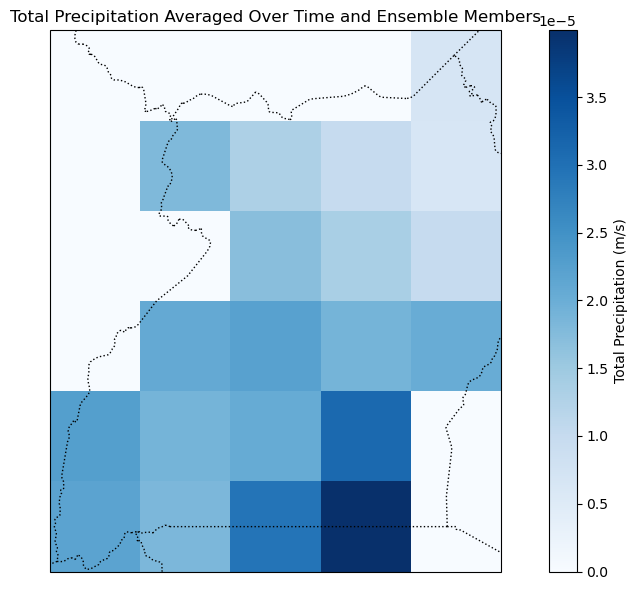

In [39]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# Load your dataset


#ds = xr.open_dataset("clipped_kenya_tprate.nc")
ecmwf = ecmwf.rio.write_crs("EPSG:4326")  # WGS84

# Use country polygons instead of boundary lines
country_set = "admin_0_countries"
shapefile_path = shpreader.natural_earth(resolution="10m", category="cultural", name=country_set)

# Ensure output directory exists
if not os.path.exists('ecmwf'):
    os.makedirs('ecmwf')

# Copy all related files
for ext in [".shp", ".shx", ".dbf", ".prj", ".cpg"]:
    source_file = str(shapefile_path).replace(".shp", ext)
    shutil.copy(source_file, os.path.join('ecmwf', os.path.basename(source_file)))

# Load country polygons
geodf = gpd.read_file("ecmwf/ne_10m_admin_0_countries.shp")

# Filter for Kenya
kenya_geom = geodf[geodf['ADMIN'] == 'Uganda']

# Clip using polygon
clipped = ecmwf.rio.clip(kenya_geom.geometry.apply(mapping), kenya_geom.crs, drop=False, invert=False)

ds = clipped
ds = ds.assign_coords(year=ds['time'].dt.year, month=ds['time'].dt.month)
ds = ds


#obs = obs

# Convert 'step' from timedelta to days
step_days = ds['step'] / np.timedelta64(1, 'D')

# Broadcast step_days to match tprate dimensions
step_days_expanded = step_days.broadcast_like(ds['tprate'])


# Calculate total precipitation = tprate * step_days
total_precip = ds['tprate'] * step_days_expanded

# Average over time and ensemble members
avg_precip = total_precip.mean(dim=['time', 'number'])

# Sum over step to get total precipitation per location
spatial_precip = avg_precip.sum(dim='step')
#spatial_precip= spatial_precip  * 86400000



# Plot using PlateCarree projection
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
spatial_precip.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Blues', cbar_kwargs={'label': 'Total Precipitation (m/s)'})
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_title("Total Precipitation Averaged Over Time and Ensemble Members")
plt.tight_layout()
plt.show()


In [40]:
import geopandas as gpd
import rioxarray
import cartopy.io.shapereader as shpreader
from shapely.geometry import mapping
import os
import shutil
import xarray as xr

# Load Kenya polygon from Natural Earth shapefile
country_set = "admin_0_countries"
shapefile_path = shpreader.natural_earth(resolution="10m", category="cultural", name=country_set)

# Ensure shapefile components are copied to local directory
if not os.path.exists('ecmwf'):
    os.makedirs('ecmwf')

for ext in [".shp", ".shx", ".dbf", ".prj", ".cpg"]:
    source_file = str(shapefile_path).replace(".shp", ext)
    shutil.copy(source_file, os.path.join('ecmwf', os.path.basename(source_file)))

# Load country polygons and filter for Kenya
geodf = gpd.read_file("ecmwf/ne_10m_admin_0_countries.shp")
kenya_geom = geodf[geodf['ADMIN'] == 'Uganda']

# Function to clip precipitation data for a given year
def clip_precip_to_kenya(year):
    file_name = f"ecmwf/chirps-v2.0.{year}.monthly.nc"
    ds = xr.open_dataset(file_name)
    precip = ds['precip'].rio.write_crs("EPSG:4326")
    clipped = precip.rio.clip(kenya_geom.geometry.apply(mapping), kenya_geom.crs, drop=True, invert=False)
    return clipped


This provieds the data as OND average rainfall in mm/day per each lat, lon coordinate


In [41]:

# Define OND months and years of interest
ond_months = [10, 11, 12]
years = range(1993, 2017)

# Dictionary to store average daily precipitation maps for OND per year
average_daily_precip_maps = {}

for year in years:
    print(f"Processing {year}...")
    #clipped = clip_precip_to_kenya(year)  # Use your clipping function
    #clipped = kenya_data
    clipped = clip_precip_to_kenya(year)
    
    # Select OND months
    ond_data = clipped.sel(time=clipped.time.dt.month.isin(ond_months))

    def nan_sum_with_nan_if_all_nan(x, dim):
        return xr.where(x.isnull().all(dim), np.nan, x.sum(dim=dim, skipna=True))
    
    # Calculate total precipitation over OND (sum over time)
    #total_precip = ond_data.sum(dim='time') # need to put ['precip'] after ond_data when using kenya_data
    total_precip = nan_sum_with_nan_if_all_nan(ond_data, dim='time')
    
    # Calculate average daily precipitation (assuming 92 days in OND)
    avg_daily_precip = total_precip / 92
    
    # Store the result for this year
    average_daily_precip_maps[year] = avg_daily_precip

# Example: print the average daily precipitation map for 1993
print("OND average daily precipitation (mm/day) for 1993:")
print(average_daily_precip_maps[1993])


Processing 1993...
Processing 1994...
Processing 1995...
Processing 1996...
Processing 1997...
Processing 1998...
Processing 1999...
Processing 2000...
Processing 2001...
Processing 2002...
Processing 2003...
Processing 2004...
Processing 2005...
Processing 2006...
Processing 2007...
Processing 2008...
Processing 2009...
Processing 2010...
Processing 2011...
Processing 2012...
Processing 2013...
Processing 2014...
Processing 2015...
Processing 2016...
OND average daily precipitation (mm/day) for 1993:
<xarray.DataArray 'precip' (latitude: 113, longitude: 109)> Size: 49kB
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan, 4.8809433,       nan, ...,       nan,       nan,
              nan],
       [      nan, 5.074268 , 4.2572136, ...,       nan,       nan,
              nan],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,  

In [42]:
import xarray as xr

# Combine all yearly precipitation maps into a single xarray DataArray
# average_daily_precip_maps should be a dictionary like {1993: DataArray, ..., 2016: DataArray}
all_years_data = xr.concat(list(average_daily_precip_maps.values()), dim='year')

# Compute the mean across the 'year' dimension
mean_precip_all_years = all_years_data.mean(dim='year')

# Print or save the result
print("Average OND precipitation (mm/day) across all years for each grid cell:")
print(mean_precip_all_years)


Average OND precipitation (mm/day) across all years for each grid cell:
<xarray.DataArray 'precip' (latitude: 113, longitude: 109)> Size: 49kB
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan, 5.7910533,       nan, ...,       nan,       nan,
              nan],
       [      nan, 6.098385 , 5.189979 , ...,       nan,       nan,
              nan],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]], dtype=float32)
Coordinates:
  * latitude     (latitude) float32 452B -1.425 -1.375 -1.325 ... 4.125 4.175
  * longitude    (longitude) float32 436B 29.57 29.62 29.68 ... 34.93 34.97
    spatial_ref  int64 8B 0


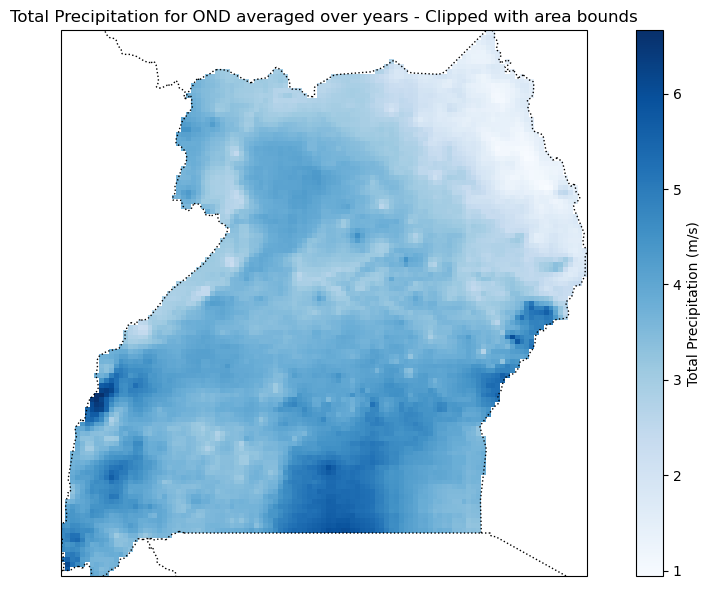

In [43]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# Plot using PlateCarree projection
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
mean_precip_all_years.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Blues', cbar_kwargs={'label': 'Total Precipitation (m/s)'})
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_title("Total Precipitation for OND averaged over years - Clipped with area bounds")
plt.tight_layout()
plt.show()

# import xarray as xr
# import numpy as np
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature

# # Define Kenya's geographic bounds
# kenya_bounds = {
#     'lat_min': -10,
#     'lat_max': 25.0,
#     'lon_min': 20,
#     'lon_max': 40.0
# }

# # Clip the dataset to Kenya's bounds
# mean_precip_kenya = mean_precip_all_years.sel(
#     latitude=slice(kenya_bounds['lat_min'], kenya_bounds['lat_max']),
#     longitude=slice(kenya_bounds['lon_min'], kenya_bounds['lon_max'])
# )

# # Plot using PlateCarree projection
# plt.figure(figsize=(10, 6))
# ax = plt.axes(projection=ccrs.PlateCarree())
# mean_precip_kenya.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Blues', cbar_kwargs={'label': 'Total Precipitation (m/s)'})
# ax.coastlines()
# ax.add_feature(cfeature.BORDERS, linestyle=':')
# ax.set_extent([kenya_bounds['lon_min'], kenya_bounds['lon_max'], kenya_bounds['lat_min'], kenya_bounds['lat_max']], crs=ccrs.PlateCarree())
# ax.set_title("Total Precipitation for OND averaged over years - Kenya")
# plt.tight_layout()
# plt.show()


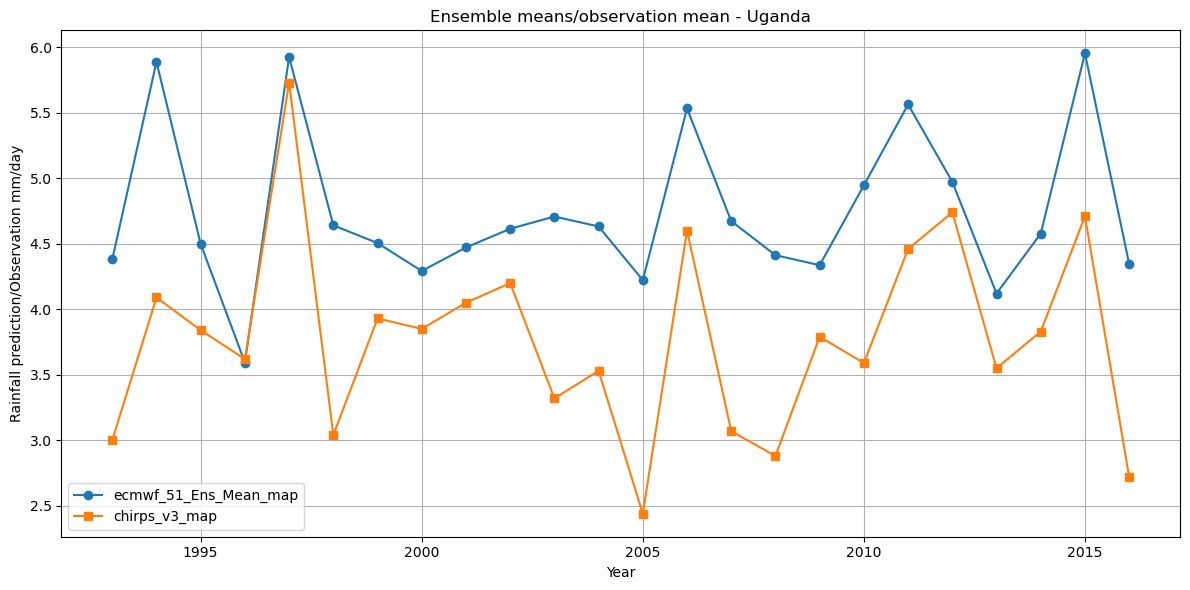

In [44]:
import matplotlib.pyplot as plt

# Years from 1993 to 2016
years = list(range(1993, 2017))
years2 = list(range(1993, 2017))

#Chirps3 = [1.68, 3.1, 2.04, 1.54, 5.85, 1.23, 2.17, 2.09, 2.04, 2.91, 1.92, 2.3, 1.1, 4.4, 1.75, 1.8, 2.57, 1.48, 3.68, 2.64, 2.07, 2.15, 3.09, 1.72]
#Chirps_with_0 = [1.04, 1.92, 1.26, 0.95, 3.63, 0.76, 1.34, 1.3, 1.27, 1.8, 1.19, 1.43, 0.68, 2.73, 1.08, 1.12, 1.59, 0.92, 2.28, 1.64, 1.28, 1.34, 1.92, 1.06]


Obs_Rain =  [1.52,2.93,1.95,1.51,5.56,1.33,2.04,2.34,1.99,2.95,1.90,2.40,1.15,4.31,1.83,1.98,2.65,1.55,3.86,2.72,2.25,2.31,3.13,1.70]
# Plotting both datasets
plt.figure(figsize=(12, 6))
plt.plot(years, ensemble_mean['tprate'], marker='o', label='ecmwf_51_Ens_Mean_map')
#plt.plot(years, excell_mean_member, marker='s', label='XEL')
#plt.plot(years, Obs_Rain, marker='s', label='Obs-excell')
#plt.plot(years, filtered_obs['tp'], marker = 's', label = 'era5')
plt.plot(years2, precip_values, marker = 's', label = 'chirps_v3_map')
#plt.plot(years2, Chirps3, marker = 's', label = 'chirps_with_nan')
#plt.plot(years2, Chirps_with_0, marker = 's', label = 'chirps_with_0')



# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Rainfall prediction/Observation mm/day')
plt.title('Ensemble means/observation mean - Uganda')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()